In [ ]:
#Setup & Download Food-101 Dataset + Required Packages

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import kagglehub
path = kagglehub.dataset_download("kmader/food41")
print("Downloaded to:", path)

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import models
from torchvision.transforms import InterpolationMode
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
from torch.optim.lr_scheduler import CosineAnnealingLR

import timm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Downloaded to: /kaggle/input/food41


Set paths and load JSON files

In [ ]:
import os
import json
import random
from sklearn.model_selection import train_test_split

# Set Kaggle Food101  image paths
meta_path = "/kaggle/input/food41/meta/meta"
images_path = "/kaggle/input/food41/images"

# Load JSON files
with open(os.path.join(meta_path, "train.json")) as f:
    train_data = json.load(f)

with open(os.path.join(meta_path, "test.json")) as f:
    test_data = json.load(f)

# Class to index mapping
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(train_data.keys())}






In [ ]:
#Data Preparation (Train/Val/Test Split)
import os
import json
from sklearn.model_selection import train_test_split

meta_path = "/kaggle/input/food41/meta/meta"
images_path = "/kaggle/input/food41/images"

with open(os.path.join(meta_path, "train.json")) as f:
    full_train_data = json.load(f)

train_split = {}
val_split = {}
test_split = {}

for cls, images in full_train_data.items():
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_split[cls] = train_imgs
    val_split[cls] = val_imgs

with open(os.path.join(meta_path, "test.json")) as f:
    test_split = json.load(f)


In [ ]:
#PyTorch Dataset
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
class Food101Dataset(Dataset):
    def __init__(self, data_dict, images_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(data_dict))}
        for cls, items in data_dict.items():
            label = self.class_to_idx[cls]
            for img in items:
                img_path = os.path.join(images_path, f"{img}.jpg")
                print(f"Checking image: {img_path}")  # Debugging line
                self.image_paths.append(img_path)
                self.labels.append(label)
        print(f"Dataset initialized with {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label



#Transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.ToTensor(),
    tranforms.RandomGrayscale(p=0.05),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomRotation(15),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1))
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])



In [ ]:
#DataLoaders
from torch.utils.data import DataLoader
print(" Creating train_dataset")
train_dataset = Food101Dataset(train_split, images_path, transform=train_transform)
val_dataset = Food101Dataset(val_split, images_path, transform=val_transform)
test_dataset = Food101Dataset(test_split, images_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


Streaming output truncated to the last 5000 lines.
Checking image: /kaggle/input/food41/images/takoyaki/1010258.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1022404.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1043001.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1046921.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1055534.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1085743.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1093318.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1103395.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1115739.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1115909.jpg
Checking image: /kaggle/input/food41/images/takoyaki/111766.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1122579.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1128320.jpg
Checking image: /kaggle/input/food41/images/takoyaki/1133698.jpg
Checking image: /kaggle/input/food41/ima

In [ ]:
#Image Count
train_count = sum(len(imgs) for imgs in train_split.values())
val_count = sum(len(imgs) for imgs in val_split.values())
test_count = sum(len(imgs) for imgs in test_split.values())

print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")




Train images: 60600
Validation images: 15150
Test images: 25250


In [ ]:
#Model Definition & Setup
import timm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading EfficientNet-B3 with pretrained weights
model = timm.create_model('efficientnet_b3', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # regularization
    nn.Linear(model.classifier.in_features, 101)
)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # label smoothing helps generalize
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs=20, patience=3):
    best_acc = 0
    epochs_no_improve = 0

    # Initializing lists to store loss and accuracy for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\n📚 Epoch {epoch+1}/{epochs}")

        # --- Training ---
        model.train()
        train_loss, train_acc = 0, 0


        for imgs, labels in tqdm(train_loader, desc=" Training", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (output.argmax(1) == labels).float().mean().item()

        # Calculate average training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader) * 100
        print(f" Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}%")

        # --- Validation ---
        model.eval()
        val_loss, val_acc = 0, 0


        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=" Validating", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)

                output = model(imgs)
                loss = criterion(output, labels)
                val_loss += loss.item()
                val_acc += (output.argmax(1) == labels).float().mean().item()

        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader) * 100
        print(f" Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.2f}%")

        # Storing loss and accuracy for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)

        # --- Early Stopping Check ---
        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_efficientnet_model.pth')
            print(f"💾 Model saved at epoch {epoch+1} with Val Acc: {avg_val_acc:.2f}%")
        else:
            epochs_no_improve += 1
            print(f" No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f" Early stopping at epoch {epoch+1}. Best Val Acc: {best_acc:.2f}%")
            break

    # Plotting the Training/Validation Loss and Accuracy
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Val Loss", color="red")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color="blue")
    plt.plot(val_accuracies, label="Val Accuracy", color="red")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()





📚 Epoch 1/20


✅ Train Loss: 2.5865 | Train Acc: 49.11%


🎯 Val Loss: 1.8917 | Val Acc: 67.41%
💾 Model saved at epoch 1 with Val Acc: 67.41%

📚 Epoch 2/20


✅ Train Loss: 1.8539 | Train Acc: 68.55%


🎯 Val Loss: 1.6908 | Val Acc: 72.73%
💾 Model saved at epoch 2 with Val Acc: 72.73%

📚 Epoch 3/20


✅ Train Loss: 1.6133 | Train Acc: 75.63%


🎯 Val Loss: 1.5966 | Val Acc: 75.31%
💾 Model saved at epoch 3 with Val Acc: 75.31%

📚 Epoch 4/20


✅ Train Loss: 1.4584 | Train Acc: 80.54%


🎯 Val Loss: 1.5602 | Val Acc: 76.67%
💾 Model saved at epoch 4 with Val Acc: 76.67%

📚 Epoch 5/20


✅ Train Loss: 1.3324 | Train Acc: 84.36%


🎯 Val Loss: 1.5452 | Val Acc: 77.01%
💾 Model saved at epoch 5 with Val Acc: 77.01%

📚 Epoch 6/20


✅ Train Loss: 1.2383 | Train Acc: 87.16%


🎯 Val Loss: 1.5410 | Val Acc: 77.33%
💾 Model saved at epoch 6 with Val Acc: 77.33%

📚 Epoch 7/20


✅ Train Loss: 1.1582 | Train Acc: 89.94%


🎯 Val Loss: 1.5556 | Val Acc: 77.36%
💾 Model saved at epoch 7 with Val Acc: 77.36%

📚 Epoch 8/20


✅ Train Loss: 1.0959 | Train Acc: 92.04%


🎯 Val Loss: 1.5655 | Val Acc: 77.16%
⚠️ No improvement for 1 epoch(s)

📚 Epoch 9/20


✅ Train Loss: 1.0461 | Train Acc: 93.64%


🎯 Val Loss: 1.5587 | Val Acc: 77.43%
💾 Model saved at epoch 9 with Val Acc: 77.43%

📚 Epoch 10/20


✅ Train Loss: 1.0122 | Train Acc: 94.65%


🎯 Val Loss: 1.5791 | Val Acc: 77.48%
💾 Model saved at epoch 10 with Val Acc: 77.48%

📚 Epoch 11/20


✅ Train Loss: 0.9794 | Train Acc: 95.70%


🎯 Val Loss: 1.5878 | Val Acc: 77.29%
⚠️ No improvement for 1 epoch(s)

📚 Epoch 12/20


✅ Train Loss: 0.9554 | Train Acc: 96.50%


🎯 Val Loss: 1.5909 | Val Acc: 77.13%
⚠️ No improvement for 2 epoch(s)

📚 Epoch 13/20


✅ Train Loss: 0.9387 | Train Acc: 96.88%


🎯 Val Loss: 1.6002 | Val Acc: 76.91%
⚠️ No improvement for 3 epoch(s)
⛔ Early stopping at epoch 13. Best Val Acc: 77.48%


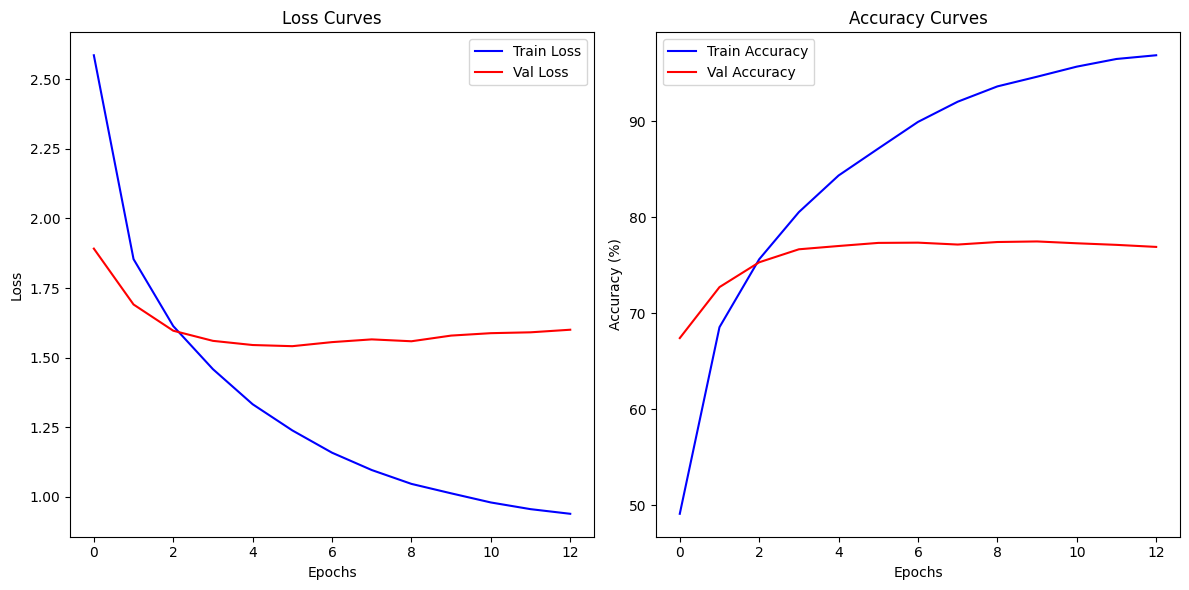

In [ ]:
#Trainging the model
train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs=20, patience=3)

In [1]:
#Evaluating model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="🧪 Testing"):
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, 1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    return np.array(y_true), np.array(y_pred)


KeyboardInterrupt: 

In [ ]:
#Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names, top_n=None):
    cm = confusion_matrix(y_true, y_pred)
    if top_n:
        # Get top_n classes with highest number of samples (to avoid clutter)
        class_counts = np.bincount(y_true)
        top_classes = np.argsort(class_counts)[-top_n:]
        cm = cm[top_classes][:, top_classes]
        labels = [class_names[i] for i in top_classes]
    else:
        labels = class_names

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("🔷 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
#Top confused Classes
def get_top_confused_classes(y_true, y_pred, class_names, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)
    confused_scores = cm.sum(axis=1)
    top_confused_indices = confused_scores.argsort()[-top_n:][::-1]
    print("\n Top Confused Classes:")
    for idx in top_confused_indices:
        print(f"- {class_names[idx]} (Confused {confused_scores[idx]} times)")
#Top Performing Classes
def get_top_performing_classes(y_true, y_pred, class_names, top_n=10):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    class_f1s = [(cls, report[cls]["f1-score"]) for cls in report if cls in class_names]
    top_classes = sorted(class_f1s, key=lambda x: x[1], reverse=True)[:top_n]
    print("\n✅ Top Performing Classes (F1-score):")
    for cls, score in top_classes:
        print(f"- {cls}: {score:.2f}")


In [ ]:
import json
import os

# Load class names from your original JSON (sorted for consistent label order)
meta_path = "/kaggle/input/food41/meta/meta"
with open(os.path.join(meta_path, "train.json")) as f:
    train_json = json.load(f)

# Class names sorted alphabetically (same as PyTorch class-to-index convention)
class_names = sorted(train_json.keys())


In [ ]:
#Classification Report
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("📊 Classification Report:\n")
    print(report)


🧪 Testing: 100%|██████████| 395/395 [02:25<00:00,  2.72it/s]


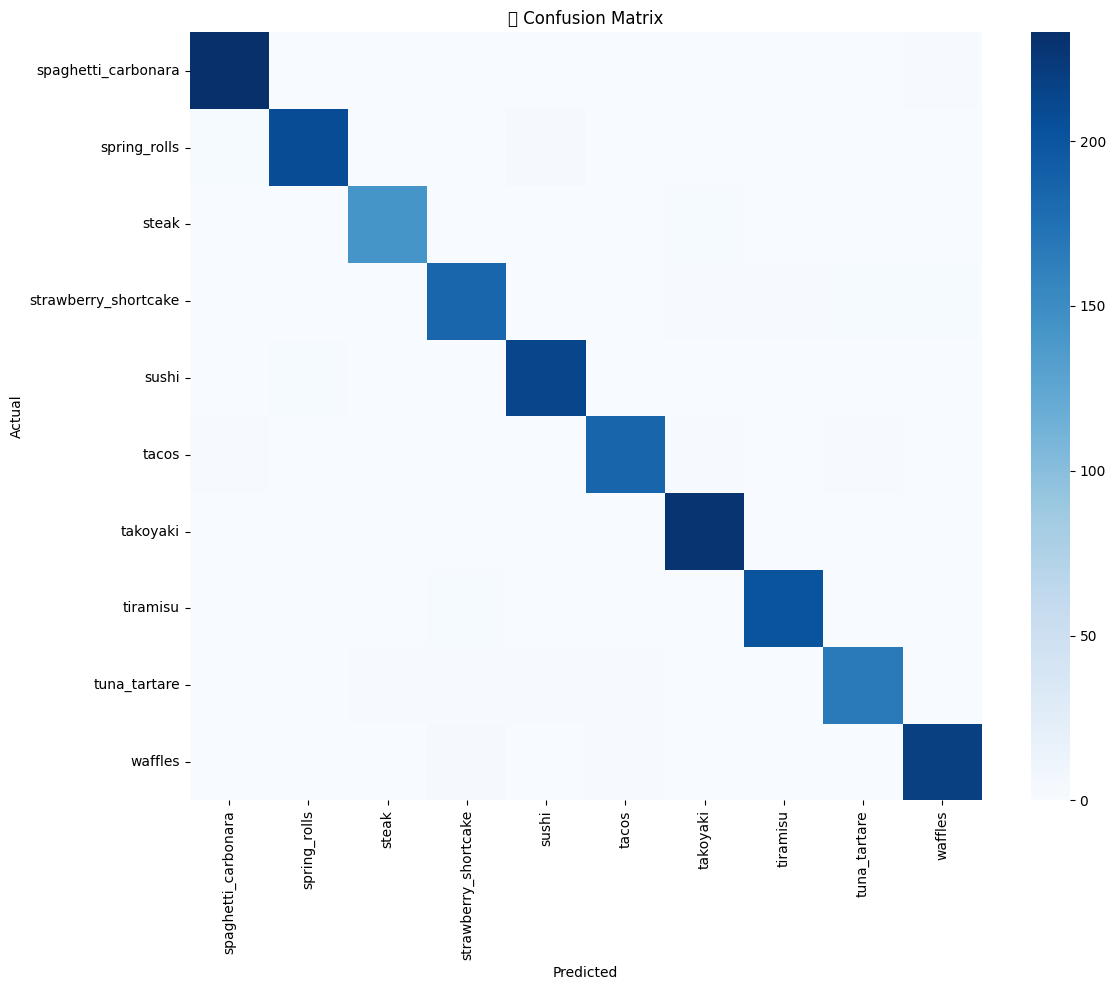

📊 Classification Report:

                         precision    recall  f1-score   support

              apple_pie       0.65      0.60      0.62       250
         baby_back_ribs       0.80      0.82      0.81       250
                baklava       0.87      0.88      0.87       250
         beef_carpaccio       0.81      0.88      0.85       250
           beef_tartare       0.84      0.69      0.76       250
             beet_salad       0.64      0.75      0.69       250
               beignets       0.89      0.90      0.90       250
               bibimbap       0.92      0.92      0.92       250
          bread_pudding       0.63      0.61      0.62       250
      breakfast_burrito       0.84      0.75      0.79       250
             bruschetta       0.65      0.80      0.72       250
           caesar_salad       0.85      0.86      0.85       250
                cannoli       0.94      0.87      0.90       250
          caprese_salad       0.78      0.84      0.81       25

In [ ]:
# Step 1: Evaluate on test set

y_true, y_pred = evaluate_model(model, test_loader, class_names)

# Step 2: Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_names, top_n=10)  # Top 10 classes

# Step 3: Classification Report
print_classification_report(y_true, y_pred, class_names)

# Step 4: Most Confused
get_top_confused_classes(y_true, y_pred, class_names, top_n=10)

# Step 5: Top Performing
get_top_performing_classes(y_true, y_pred, class_names, top_n=10)


In [ ]:
from sklearn.metrics import accuracy_score  # ← This is what was missing!

# Calculate and print test accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


✅ Test Accuracy: 81.79%


In [ ]:
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("📊 Classification Report:\n")
    print(report)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Find most confused classes (not counting the diagonal)
    confusion_scores = cm.copy()
    np.fill_diagonal(confusion_scores, 0)
    confused_pairs = np.dstack(np.unravel_index(np.argsort(confusion_scores.ravel())[::-1], cm.shape))[0]
#Top confused Class Pairs
    print("\n Top Confused Class Pairs:")
    printed = 0
    used = set()
    for i, j in confused_pairs:
        if printed >= top_n or (i, j) in used or (j, i) in used:
            continue
        print(f"- {class_names[i]} ↔ {class_names[j]} | Mistakes: {cm[i][j] + cm[j][i]}")
        used.add((i, j))
        printed += 1
#Top Performing Classes by Precision
def plot_top_classes(y_true, y_pred, class_names, top_n=10):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    accuracies = {k: v["precision"] for k, v in report.items() if k in class_names}

    top_classes = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)[:top_n]
    names = [x[0] for x in top_classes]
    values = [x[1] for x in top_classes]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=values, y=names, palette="viridis")
    plt.title(" Top Performing Classes by Precision")
    plt.xlabel("Precision")
    plt.xlim(0, 1)
    plt.show()



🔄 Top Confused Class Pairs:
- filet_mignon ↔ steak | Mistakes: 83
- steak ↔ prime_rib | Mistakes: 53
- pork_chop ↔ steak | Mistakes: 36
- chocolate_cake ↔ chocolate_mousse | Mistakes: 45
- red_velvet_cake ↔ carrot_cake | Mistakes: 39
- bread_pudding ↔ apple_pie | Mistakes: 39
- scallops ↔ foie_gras | Mistakes: 23
- beef_tartare ↔ tuna_tartare | Mistakes: 36
- chocolate_mousse ↔ tiramisu | Mistakes: 28
- risotto ↔ fried_rice | Mistakes: 24


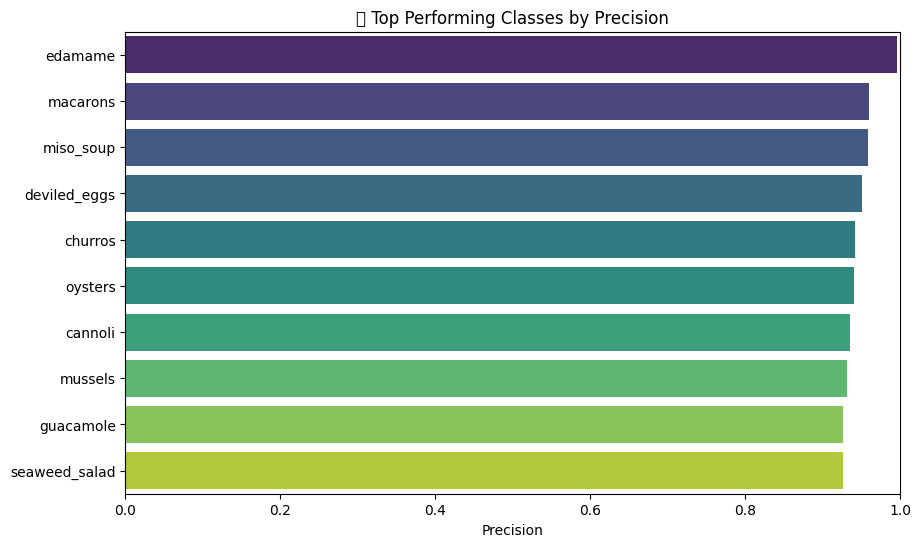

In [ ]:
#Plottinng top confused pairs and top performing classes

plot_confusion_matrix(y_true, y_pred, class_names, top_n=10)
plot_top_classes(y_true, y_pred, class_names, top_n=10)


In [ ]:
#Worst classes by precision
def plot_worst_classes(y_true, y_pred, class_names, top_n=10):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    precisions = {k: v["precision"] for k, v in report.items() if k in class_names}

    # Sort by lowest precision
    worst_classes = sorted(precisions.items(), key=lambda x: x[1])[:top_n]
    names = [x[0] for x in worst_classes]
    values = [x[1] for x in worst_classes]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=values, y=names, palette="Reds_r")
    plt.title("💀 Worst Performing Classes by Precision")
    plt.xlabel("Precision")
    plt.xlim(0, 1)
    plt.show()


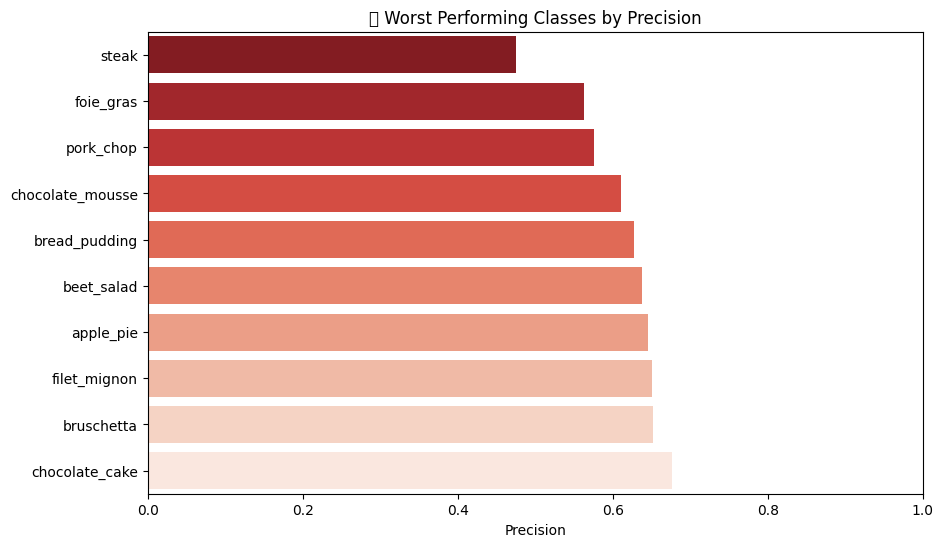

In [ ]:
plot_worst_classes(y_true, y_pred, class_names, top_n=10)


In [ ]:
#Saving the model
torch.save(model.state_dict(), "best_efficientnet_model.pth")
